In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import warnings
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
from torchvision.transforms import functional as F

warnings.filterwarnings("ignore")

In [226]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

True
1
NVIDIA GeForce GTX 1050


In [227]:
train_data = pd.read_csv('data/train.csv')

train_data.head()

,id,title,body,label
0,0,Ok guys I have a dilemma for you,Ok so I’m thinking about asking out this girl ...,0.0
1,1,Update from my cringe overdramatic ass post,56 days ago from today I posted about my then-...,0.0
2,2,"Don't know if this is allowed, I work in youth...",NaN,0.0
3,3,So I think I just ascended to a newer level of...,So I was rebattling the elite four in Pokemon ...,0.0
4,4,My friend got a gf before me,But I have more reddit karma so I think I win 😎,0.0


In [228]:
cut_train_lables = []
cut_train_dataset = []

for i in range(len(train_data)):
    combined_text = train_data['title'][i] + " " + train_data['body'][i] if pd.notna(train_data['body'][i]) else train_data['title'][i]
    while len(combined_text) > 512:
        cut_train_dataset.append(combined_text[:512])
        cut_train_lables.append(train_data['label'][i])
        combined_text = combined_text[512:]
    cut_train_dataset.append(combined_text)
    cut_train_lables.append(train_data['label'][i])


print(len(cut_train_lables))
print(len(cut_train_dataset))

16219
16219


In [229]:
import sentencepiece as spm

# Обучаем токенайзер
spm.SentencePieceTrainer.train(input='data/train.csv', model_prefix='depression', vocab_size=700, model_type='bpe')

# Загружаем обученный токенайзер
sp = spm.SentencePieceProcessor();
sp.load('depression.model') # загружаем модель в файл

# Токенизация текста
tokens = sp.encode_as_pieces('Update from my cringe overdramatic ass post')
print("Tokens:", tokens)
print(len(tokens))

# Детокенизация
detokenized_text = sp.decode_pieces(tokens)
print("Detokenized text:", detokenized_text)
print(len(detokenized_text))

Tokens: ['▁', 'U', 'p', 'd', 'ate', '▁from', '▁my', '▁c', 'r', 'ing', 'e', '▁over', 'd', 'ra', 'm', 'at', 'ic', '▁a', 'ss', '▁post']
20
Detokenized text: Update from my cringe overdramatic ass post
43


In [230]:
class SPTokenizer:
    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)
        self.int2voc = {i: self.sp.id_to_piece(i).replace('▁', ' ') for i in range(self.sp.get_piece_size())}
        self.voc2int = {v: k for k, v in self.int2voc.items()}
        self._add_special("<pad>")
        self.pad_index = len(self.voc2int)
        self._add_special("<pad>")
    
    def _add_special(self, symbol) -> None:
        idx = len(self.voc2int)
        if symbol not in self.voc2int:
            self.voc2int[symbol] = idx
            self.int2voc[idx] = symbol

    @property
    def vocab_size(self):
        return len(self.voc2int)
        
    def encode(self, text):
        #return torch.tensor(self.sp.encode_as_ids(text))
        #text = '<bos>' + text
        return torch.tensor(self.str_to_idx(text))
        
    def decode(self, ids):
        #return self.sp.decode_ids(ids.tolist())
        chars = self.idx_to_str(ids.tolist())
        return ''.join(chars) # make string from list

    def encode_symbol(self, symbol):
        return self.voc2int.get(symbol, self.voc2int['<unk>'])  # Обработка неизвестных символов
    
    def decode_symbol(self, id):
        #return self.sp.id_to_piece(id)
        return self.int2voc.get(id, '<unk>')  # Обработка неизвестных символов

    def str_to_idx(self, chars):
        return self.sp.encode_as_ids(chars)

    def idx_to_str(self, idx):
        return [self.decode_symbol(i) for i in idx] # list[int] -> list[str]

In [231]:
tokenizer = SPTokenizer('depression.model')

encoded_text = tokenizer.encode("Update from my cringe overdramatic ass post")
print("Encoded text:", encoded_text)

decoded_text = tokenizer.decode(encoded_text)
print("Decoded text:", decoded_text)

print(tokenizer.vocab_size)
print(len(encoded_text))
print(len(decoded_text))

Encoded text: tensor([488, 559, 508, 499, 253, 259,  41,  24, 497,  17, 489, 369, 499, 139,
        500,  58,  74,   4, 125, 415])
Decoded text:  Update from my cringe overdramatic ass post
701
20
44


In [233]:
X = []

for i in range(len(cut_train_dataset)):
    encoded = tokenizer.encode(cut_train_dataset[i])
    padded_encoded = torch.cat((encoded, torch.tensor([tokenizer.pad_index] * (512 - len(encoded)))), dim=0)
    if len(padded_encoded) != 512:  # Дополнение до max_len
        padded_encoded = padded_encoded[:512]  # Обрезка до длины 512
        print(len(padded_encoded))
    X.append(padded_encoded)


print(X[0])
print(cut_train_dataset[0])

512
512
tensor([367, 512, 276, 365,   9,  95,   4, 266,  45, 500, 500, 492,  83,  68,
        367, 512,  60,   9, 520, 500, 224, 172, 163, 142, 172, 157, 113, 384,
        246,   9, 225, 360, 507, 126,  74, 496, 404, 493, 520, 490,   7,  16,
         15, 117,   4,  13, 350, 154,  72, 507,   9, 164, 509, 330, 527, 129,
        383,   9, 142, 340, 179, 157, 144,  23, 342,  47, 278, 491,  21, 500,
        511,  34, 507,  27, 178, 435,  48, 489, 492, 496, 507, 105, 370,   4,
        442, 512,  26,  58,  34, 178, 435, 488, 599, 510, 520, 500, 120,  71,
         94, 502,  83,   4,  71, 498, 241, 309, 388,  48,  93, 520, 162, 368,
        219, 504, 489, 176, 328, 140, 528,  27, 132,  35, 131,  47, 433,  95,
        232,  13, 506, 495, 545, 503, 506, 495,  40, 472, 543, 380, 489, 196,
         47, 113, 141, 511, 488, 547,  32, 454,  22, 320, 508, 251, 236, 491,
         73,   8,  53, 499,  97,  69,  50,  24, 177,   9, 344, 251, 432, 513,
        363, 701, 701, 701, 701, 701, 701, 701, 701, 701

In [234]:
# Разделение cut_train_dataset на обучающую и тестовую выборки
X_train_cut, X_test_cut, y_train_cut, y_test_cut = train_test_split(X, cut_train_lables, test_size=0.2, random_state=42)

print(len(X_train_cut))
print(len(X_test_cut))
print(len(y_train_cut))
print(len(y_test_cut))


12975
3244
12975
3244


In [235]:
# Создание пользовательского датасета
class PostsDataset(Dataset):
    def __init__(self, texts, labels, max_len: int = 512):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.float32)

        #return {'text': self.texts[idx], 'label': torch.tensor(self.labels[idx])}
        return text, self.labels[idx]

# Создание DataLoader
train_dataset = PostsDataset(X_train_cut, y_train_cut)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [264]:
# Определение модели LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавляем размерность для последовательности
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Берем последний временной шаг
        return self.sigmoid(out)

In [265]:
# Параметры модели
input_size = len(X[1])
hidden_size = 64  # Размер скрытого слоя
output_size = 1  # Выходной размер (1 для бинарной классификации)

# Инициализация модели, критерия и оптимизатора
model = LSTM(input_size, hidden_size, output_size).to(device)
criterion = nn.BCEWithLogitsLoss()  # Критерий для оценки вероятности бинарной метки
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [266]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

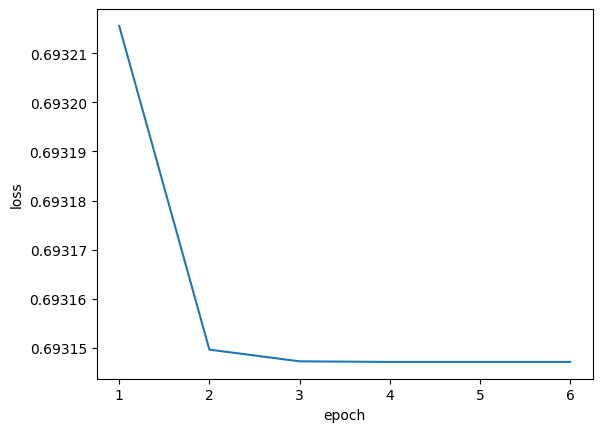

KeyboardInterrupt: 

In [267]:
# Обучение модели
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    for text, label in train_loader:
        text = text.to(device)  # Перемещаем текст на устройство
        label = label.to(device)  # Перемещаем метку на устройство
        optimizer.zero_grad()
        outputs = model(text)
        # Убедитесь, что выход имеет правильную размерность
        loss = criterion(outputs.view(-1), label.float())  # Изменение здесь
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

    plot_losses(losses)

In [286]:
model1 = model.eval()

# Выводим предсказанные вероятности
def predict(title, body):
        with torch.no_grad():  
                encoded = tokenizer.encode(title + " " + body)
                encoded = torch.tensor(encoded, dtype=torch.float32).to(device)  # Перемещаем на устройство
                predictions = []

                while len(encoded) > 512:
                    prediction = model1(encoded[:512].unsqueeze(0).to(device)).item()  # Добавляем размерность и перемещаем на устройство
                    predictions.append(prediction)
                    encoded = encoded[512:]

                padded_encoded = torch.cat((encoded, torch.tensor([tokenizer.pad_index] * (512 - len(encoded)), dtype=torch.float32).to(device)), dim=0)  # Перемещаем на устройство
                prediction = model1(padded_encoded.unsqueeze(0)[:512].to(device)).item()  # Добавляем размерность и перемещаем на устройство, переводим в число
                predictions.append(prediction) 
                lable = sum(predictions) / len(predictions) if predictions else 0
                
                return lable


In [5]:
test_data = pd.read_csv('data/test.csv')
test_data.head()

,id,title,body
0,0,I just really want some sushi,Hey
1,1,My dog is naked,Is this a felony
2,2,My brother is one of those obnoxious cunts who...,Fuck him I hate those people who think they're...
3,3,What are you guys doing?,I'm bored who wants to talk
4,4,"Problems at home, it hurts.","Hi, my name is Scott and i'm 16 years old and ..."


In [292]:
# Создание файла submission.csv
submission_data = []
for i in range(len(test_data)):
    lable = predict(test_data['title'][i], test_data['body'][i])
    submission_data.append({'id': i, 'label': 0 if label < 0.5 else 1})  # Сохраняем id и метку

# Добавляем шапку в датасет
df = pd.DataFrame(submission_data)  # Создаем DataFrame из submission_data

df.to_csv("submission1.csv", index=False)